In [100]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib as plt
from statsmodels.sandbox.stats.multicomp import multipletests 

In [20]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/ivan/anaconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['exp']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


В данном задании вам нужно будет

* проанализировать АБ тест, проведенный на реальных пользователях Яндекса
* подтвердить или опровергнуть наличие изменений в пользовательском поведении между контрольной (control) и тестовой (exp) группами
* определить характер этих изменений и практическую значимость вводимого изменения
* понять, какая из пользовательских групп более всего проигрывает / выигрывает от тестируемого изменения (локализовать изменение)

Описание данных:

* userID: уникальный идентификатор пользователя
* browser: браузер, который использовал userID
* slot: в каком статусе пользователь участвовал в исследовании (exp = видел измененную страницу, control = видел неизменную страницу)
* n_clicks: количество кликов, которые пользоваль совершил за n_queries
* n_queries: количество запросов, который совершил userID, пользуясь браузером browser
* n_nonclk_queries: количество запросов пользователя, в которых им не было совершено ни одного клика

Обращаем ваше внимание, что не все люди используют только один браузер, поэтому в столбце userID есть повторяющиеся идентификаторы. В предлагаемых данных уникальным является сочетание userID и browser.

ab_browser_test.csv
Основная метрика, на которой мы сосредоточимся в этой работе, — это количество пользовательских кликов на web-странице в зависимости от тестируемого изменения этой страницы.

Посчитайте, насколько в группе exp больше пользовательских кликов по сравнению с группой control в $процентах$ от числа кликов в контрольной группе.

Полученный процент округлите до третьего знака после точки.

In [3]:
data = pd.read_csv('ab_browser_test.csv', sep = ',', header = 0)

In [4]:
data.head()

,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries
0,1,Browser #2,exp,23,32,19
1,3,Browser #4,exp,3,4,2
2,5,Browser #4,exp,29,35,16
3,6,Browser #4,control,12,6,0
4,7,Browser #4,exp,54,68,30


In [46]:
exp = data[data.slot == 'exp']
control = data[data.slot == 'control']

In [6]:
(sum(exp.n_clicks.values) - sum(control.n_clicks.values))/float(sum(control.n_clicks.values))*100

1.6135689824415809

Давайте попробуем посмотреть более внимательно на разницу между двумя группами (control и exp) относительно количества пользовательских кликов.

Для этого постройте с помощью бутстрепа 95% доверительный интервал для средних значений и медиан количества кликов в каждой из двух групп. Отметьте все верные утверждения.

In [7]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [8]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

Доверительные интервалы для медиан

In [9]:
np.random.seed(0)

exp_n_clicks_median_scores = map(np.median, get_bootstrap_samples(exp.n_clicks.values, 500))
control_n_clicks_median_scores = map(np.median, get_bootstrap_samples(control.n_clicks.values , 500))

print "95% confidence interval for the exp median number of clicks:", stat_intervals(exp_n_clicks_median_scores , 0.05)
print "95% confidence interval for the control median number of clicks:", stat_intervals(control_n_clicks_median_scores , 0.05)

95% confidence interval for the exp median number of clicks: [ 5.  5.]
95% confidence interval for the control median number of clicks: [ 4.  4.]


In [11]:
delta_median_scores = map(lambda x: x[1] - x[0], zip(exp_n_clicks_median_scores, control_n_clicks_median_scores))
print "95% confidence interval for the difference between medians",  stat_intervals(delta_median_scores, 0.05)

95% confidence interval for the difference between medians [-1. -1.]


Доверительные интервалы для средних

In [10]:
np.random.seed(0)

exp_n_clicks_mean_scores = map(np.mean, get_bootstrap_samples(exp.n_clicks.values, 500))
control_n_clicks_mean_scores = map(np.mean, get_bootstrap_samples(control.n_clicks.values , 500))

print "95% confidence interval for the exp mean number of clicks:", stat_intervals(exp_n_clicks_mean_scores , 0.05)
print "95% confidence interval for the control mean number of clicks:", stat_intervals(control_n_clicks_mean_scores , 0.05)

95% confidence interval for the exp mean number of clicks: [ 11.50789349  11.6588664 ]
95% confidence interval for the control mean number of clicks: [ 11.20668696  11.35347509]


In [12]:
delta_mean_scores = map(lambda x: x[1] - x[0], zip(exp_n_clicks_mean_scores, control_n_clicks_mean_scores))
print "95% confidence interval for the difference between medians",  stat_intervals(delta_mean_scores, 0.05)

95% confidence interval for the difference between medians [-0.40496719 -0.19960335]


t-критерий Стьюдента имеет множество достоинств, и потому его достаточно часто применяют в AB экспериментах. Иногда его применение может быть необоснованно из-за сильной скошенности распределения данных.

Давайте постараемся понять, когда t-критерий можно применять и как это проверить на реальных данных.

Для простоты рассмотрим одновыборочный t-критерий. Его статистика имеет вид X¯−μS2/n√, то есть чтобы действительно предположения t-критерия выполнялись необходимо, чтобы:

* X¯ — среднее значение в выборке — было распределено нормально N(μ,σ2n)
* nσ2S2 — несмещенная оценка дисперсии c масштабирующим коэффициентом — была распределена по хи-квадрат c n−1 степенями свободы χ2(n−1)

Простое доказательство необходимости и достаточности этого требования можно посмотреть в самом последнем абзаце этого вопроса. Усвоение этого доказательства не обязательно для выполнения задания.

Оба этих предположения можно проверить с помощью бутстрепа. Ограничимся сейчас только контрольной группой, в которой распределение кликов будем называть данными в рамках данного вопроса.

Поскольку мы не знаем истинного распределения генеральной совокупности, мы можем применить бутстреп, чтобы понять, как распределены среднее значение и выборочная дисперсия. Для этого

* Получите из данных n_boot_samples псевдовыборок.
* По каждой из этих выборок посчитайте среднее и сумму квадратов отклонения от выборочного среднего (control_boot_chi_squared)
* Для получившегося вектора средних значений из n_boot_samples постройте q-q plot с помощью scipy.stats.probplot для нормального распределения
* Для получившегося вектора сумм квадратов отклонения от выборочного среднего постройте qq-plot с помощью scipy.stats.probplot для хи-квадрат распределения с помощью команды

Почему мы проверяем именно такие условия?

В исходной постановке t-критерий требует нормальности распределения Xi. Именно из-за этого предположения мы имеем, что ∑iXi∼N(nμ,nσ2) в силу линейности матожидания, независимости всех Xi между собой и того факта, что сумма нескольких нормальных случайных величин также нормальна.

Поэтому, пользуясь опять формальными свойствами матожидания и дисперсии можем записать, что 1n∑iXi−μ ∼ N(0,σ2n)

Заметим теперь, что следующие распределения эквивалентны N(0,σ2n)∼σ2n−−√N(0,1)
То есть другими словами мы получили, что исходная статистика X¯−μS2/n√ распределена как N(0,1)S2nnσ2√ ∼ N(0,1)S2σ2√
Вспомним, что распределение Стьюдента с n−1 степенями свободы определяется как N(0,1)χ2/(n−1)√. Поэтому и требования, которые накладываются, имеют вид, указанный в начале этого вопроса.

Полезно, однако, заметить, что можно подставить в числитель и знаменатель любые случайные величины, распределенные по нормальному закону и по Хи-квадрат соответственно, для этого необязательно, чтобы именно Xi были распределены нормально. Поэтому, если мы убедимся в том, что, действительно, числитель и знаменатель распределены образом, указанным выше, то можно смело использовать t-критерий Стьюдента.

In [13]:
np.random.seed(0)
n_boot_samples = 500

control_boot_mean = map(np.mean, get_bootstrap_samples(control.n_clicks.values, n_boot_samples))
control_boot_chi_squared = map(np.std, get_bootstrap_samples(control.n_clicks.values, n_boot_samples))

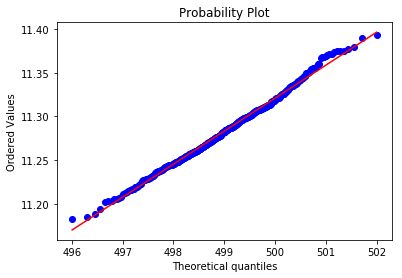

In [38]:
x1, x2 = stats.probplot(control_boot_mean, dist="norm", sparams=(n_boot_samples-1), plot=pylab)
pylab.show()

In [39]:
x2

(0.037774667185630946, -7.5663143112508493, 0.99797483646042073)

In [40]:
x2[2]*x2[2]

0.99595377420820352

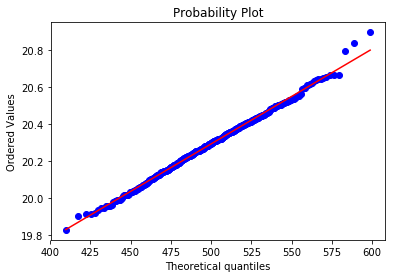

In [30]:
x1, x2 = stats.probplot(control_boot_chi_squared, dist="chi2",sparams=(n_boot_samples-1), plot=pylab)
pylab.show()

In [41]:
x2

(0.037774667185630946, -7.5663143112508493, 0.99797483646042073)

In [42]:
x2[2]*x2[2]

0.99595377420820352

Одним из возможных аналогов t-критерия, которым можно воспрользоваться, является тест Манна-Уитни. На достаточно обширном классе распределений он является асимптотически более эффективным, чем t-критерий, и при этом не требует параметрических предположений о характере распределения.

Разделите выборку на две части, соответствующие control и exp группам. Преобразуйте данные к виду, чтобы каждому пользователю соответствовало суммарное значение его кликов. С помощью критерия Манна-Уитни проверьте гипотезу о равенстве средних. Что можно сказать о получившемся значении достигаемого уровня значимости ? Выберите все правильные ответы

In [70]:
n_click_control_by_user = control.groupby(by='userID')['n_clicks'].agg(np.sum)
n_click_exp_by_user = exp.groupby(by='userID')['n_clicks'].agg(np.sum)

In [71]:
stats.mannwhitneyu(n_click_control_by_user.values, n_click_exp_by_user.values)

MannwhitneyuResult(statistic=38901259929.0, pvalue=4.3471471887604393e-75)

Проверьте, для какого из браузеров наиболее сильно выражено отличие между количеством кликов в контрольной и экспериментальной группах.

Для этого примените для каждого из срезов (по каждому из уникальных значений столбца browser) критерий Манна-Уитни между control и exp группами и сделайте поправку Холма-Бонферрони на множественную проверку с α=0.05.

Какое заключение можно сделать исходя из полученных результатов ?

В качестве ответа введите количество незначимых изменений с точки зрения результатов, полученных после введения коррекции.

In [74]:
data.browser.value_counts()

Browser #4     156833
Browser #22    142905
Browser #2     110737
Browser #14     89123
Browser #20     33929
Browser #17     32607
Name: browser, dtype: int64

In [82]:
exp4 = data[(data.browser == 'Browser #4') & (data.slot == 'exp')]
control4 = data[(data.browser == 'Browser #4') & (data.slot == 'control')]

exp22 = data[(data.browser == 'Browser #22') & (data.slot == 'exp')]
control22 = data[(data.browser == 'Browser #22') & (data.slot == 'control')]

exp2 = data[(data.browser == 'Browser #2') & (data.slot == 'exp')]
control2 = data[(data.browser == 'Browser #2') & (data.slot == 'control')]

exp14 = data[(data.browser == 'Browser #14') & (data.slot == 'exp')]
control14 = data[(data.browser == 'Browser #14') & (data.slot == 'control')]

exp20 = data[(data.browser == 'Browser #20') & (data.slot == 'exp')]
control20 = data[(data.browser == 'Browser #20') & (data.slot == 'control')]

exp17 = data[(data.browser == 'Browser #17') & (data.slot == 'exp')]
control17 = data[(data.browser == 'Browser #17') & (data.slot == 'control')]

In [83]:
p_values = []

p_values.append(stats.mannwhitneyu(exp4.n_clicks.values, control4.n_clicks.values))
p_values.append(stats.mannwhitneyu(exp22.n_clicks.values, control22.n_clicks.values))
p_values.append(stats.mannwhitneyu(exp2.n_clicks.values, control2.n_clicks.values))
p_values.append(stats.mannwhitneyu(exp14.n_clicks.values, control14.n_clicks.values))
p_values.append(stats.mannwhitneyu(exp20.n_clicks.values, control20.n_clicks.values))
p_values.append(stats.mannwhitneyu(exp17.n_clicks.values, control17.n_clicks.values))

In [96]:
p_values

[MannwhitneyuResult(statistic=3072447765.0, pvalue=0.40760617658454984),
 MannwhitneyuResult(statistic=2547597959.5, pvalue=0.25740551522100319),
 MannwhitneyuResult(statistic=1522572720.0, pvalue=0.027243860419724101),
 MannwhitneyuResult(statistic=806984730.5, pvalue=0.0),
 MannwhitneyuResult(statistic=143791805.0, pvalue=0.45366656388735377),
 MannwhitneyuResult(statistic=131389681.0, pvalue=0.037400601430108017)]

In [97]:
for i in range(6):
    p_values[i] = p_values[i][1]

In [98]:
p_values

[0.40760617658454984,
 0.25740551522100319,
 0.027243860419724101,
 0.0,
 0.45366656388735377,
 0.037400601430108017]

In [142]:
reject, p_corrected, a1, a2 = multipletests(p_values, 
                                            alpha = 0.05, 
                                            method = 'bonferroni')

In [140]:
p_corrected

array([ 1.        ,  1.        ,  0.16346316,  0.        ,  1.        ,
        0.22440361])

In [143]:
reject

array([False, False, False,  True, False, False], dtype=bool)

Для каждого браузера в каждой из двух групп (control и exp) посчитайте долю запросов, в которых пользователь не кликнул ни разу. Это можно сделать, поделив сумму значений n_nonclk_queries на сумму значений n_queries. Умножив это значение на 100, получим процент некликнутых запросов, который можно легче проинтерпретировать.

Сходятся ли результаты проведенного Вами анализа с показателем процента некликнутых запросов ? Отметьте все верные утверждения.

In [123]:
nonclk_control_by_browser = control.groupby(by='browser')['n_nonclk_queries'].agg(np.sum)
nonclk_exp_by_browser = exp.groupby(by='browser')['n_nonclk_queries'].agg(np.sum)

queries_control_by_browser = control.groupby(by='browser')['n_queries'].agg(np.sum)
queries_exp_by_browser = exp.groupby(by='browser')['n_queries'].agg(np.sum)

In [132]:
rel_control = []
rel_exp = []
for i in range(6):
    rel_control.append(nonclk_control_by_browser[i]*100/float(queries_control_by_browser[i]))
    rel_exp.append(nonclk_exp_by_browser[i]*100/float(queries_exp_by_browser[i]))

In [133]:
rel_control

[57.590411360081141,
 36.299366746282089,
 45.96274717919465,
 40.540484743383296,
 40.593976593513354,
 46.970929635142738]

In [134]:
rel_exp

[43.755617361273295,
 36.937412848664827,
 44.982746948554706,
 38.977376483717158,
 39.853947219695463,
 45.142941903584671]